<a href="https://colab.research.google.com/github/inokchoi/ComputerVision/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
cd '/content/drive/My Drive/Colab Notebooks/20-1computervision/Assignment2'

/content/drive/My Drive/Colab Notebooks/20-1computervision/Assignment2


In [ ]:
!pip install livelossplot # Beautiful liveloss plot for jupyter

In [ ]:
#!pip install torchsummary

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms
#from torchsummary import summary

from IPython.display import clear_output
from livelossplot import PlotLosses 


In [ ]:
transform = transforms.Compose([
    #transforms.Resize(227),
    transforms.Resize(32),    #Assignment2 수정 요청 사항
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data',train=True, download=True, transform=transform)
trainloader = DataLoader(trainset,batch_size=32,shuffle=True, num_workers=2)
 
testset = torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)
 
classes = ('plane','car','bird','cat','deer','dog','forg','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


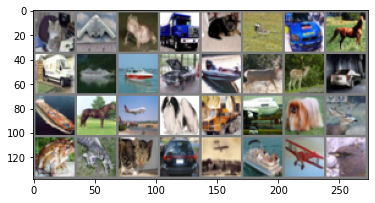

  cat plane  forg truck   dog  bird   car horse truck  ship  ship   car  ship  deer  deer   car  ship horse plane   dog truck plane   dog  deer  forg   cat   cat   car plane  ship plane  bird


In [ ]:
def imshow(img):
    img = img/2 + 0.5
    nping = img.numpy()
    plt.imshow(np.transpose(nping, (1,2,0)))
    plt.show()
 
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%classes[labels[j]] for j in range(32)))

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        '''
        self.conv1 = nn.Conv2d(3,96,11,4)
        self.conv2 = nn.Conv2d(96,256,5,padding=2,groups=2)
        self.conv3 = nn.Conv2d(256,384,3,padding=1, groups=2)
        self.conv4 = nn.Conv2d(384,384,3,padding=1, groups=2)
        self.conv5 = nn.Conv2d(384,256,3,padding=1, groups=2)
        self.fc1 = nn.Linear(256*6*6,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,num_classes)
        '''
        self.conv1 = nn.Conv2d(3,48,3)
        self.conv2 = nn.Conv2d(48,128,3,padding=2,groups=2)  #in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(128,256,3,padding=1, groups=2)
        self.conv4 = nn.Conv2d(256,256,3,padding=1, groups=2)
        self.conv5 = nn.Conv2d(256,128,3,padding=1, groups=2)
        self.fc1 = nn.Linear(128*4*4,1024)
        self.fc2 = nn.Linear(1024,1024)
        self.fc3 = nn.Linear(1024,num_classes)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(F.relu(self.conv5(x)),(2,2))
        x = x.view(x.size(0),128*4*4)
        x = F.dropout(F.relu(self.fc1(x)),p=0.5)
        x = F.dropout(F.relu(self.fc2(x)),p=0.5)
        x = self.fc3(x)
        return x

In [ ]:
#net = AlexNet()
#summary(net, input_size=(3, 32, 32))

In [ ]:
device = torch.device("cuda")
#print(device)
 
net = AlexNet()
print(net)
net.to(device)
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

AlexNet(
  (conv1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), groups=2)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (conv5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
)


height = width = sqrt( E / batch_size / n_channels)

In [ ]:
'''
liveloss = PlotLosses()

for epoch in range(20):
    
    logs = {}
    total_train = 0.0
    correct_train = 0.0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, lables = data
        inputs = inputs.to(device)
        lables = lables.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, lables)
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item()

        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += lables.size(0)
        correct_train += predicted.eq(lables.data).sum().item()

        if i % 200 == 199:
            print('[%d,%5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            logs['Training Loss'] = running_loss / 200
            running_loss = 0.0

            train_accuracy = 100 * correct_train / total_train
            logs['Training Accuracy'] = train_accuracy
            total_train = 0.0
            correct_train = 0.0

      
    #Test loss accuracy
    total_test = 0.0
    correct_test = 0.0
    #running_test_loss = 0.0
    for i, data in enumerate(testloader, 0):
        with torch.no_grad():
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            #loss = criterion(outputs, lables)
            #running_test_loss += loss.item()

            predicted = torch.argmax(outputs.data,1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            if i % 200 == 199:
                #print('[%d,%5d] loss: %.3f' % (epoch + 1, i + 1, running_test_loss / 200))
                #logs['Test Loss'] = running_test_loss / 200
                #running_test_loss = 0.0

                test_accuracy = 100 * correct_test / total_test
                logs['Test Accuracy'] = test_accuracy
                total_test = 0.0
                correct_test = 0.0
    
    liveloss.update(logs)
    liveloss.draw()
 
print('Finished Training')
torch.save(net, './model2')
'''

"\nliveloss = PlotLosses()\n\nfor epoch in range(20):\n    \n    logs = {}\n    total_train = 0.0\n    correct_train = 0.0\n    running_loss = 0.0\n    for i, data in enumerate(trainloader, 0):\n        inputs, lables = data\n        inputs = inputs.to(device)\n        lables = lables.to(device)\n        optimizer.zero_grad()\n        outputs = net(inputs)\n        loss = criterion(outputs, lables)\n        loss.backward()\n        optimizer.step()\n \n        running_loss += loss.item()\n\n        # accuracy\n        _, predicted = torch.max(outputs.data, 1)\n        total_train += lables.size(0)\n        correct_train += predicted.eq(lables.data).sum().item()\n\n        if i % 200 == 199:\n            print('[%d,%5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))\n            logs['Training Loss'] = running_loss / 200\n            running_loss = 0.0\n\n            train_accuracy = 100 * correct_train / total_train\n            logs['Training Accuracy'] = train_accuracy\n      

In [ ]:
dataloaders = {
    'train': trainloader,
    'test' : testloader
}

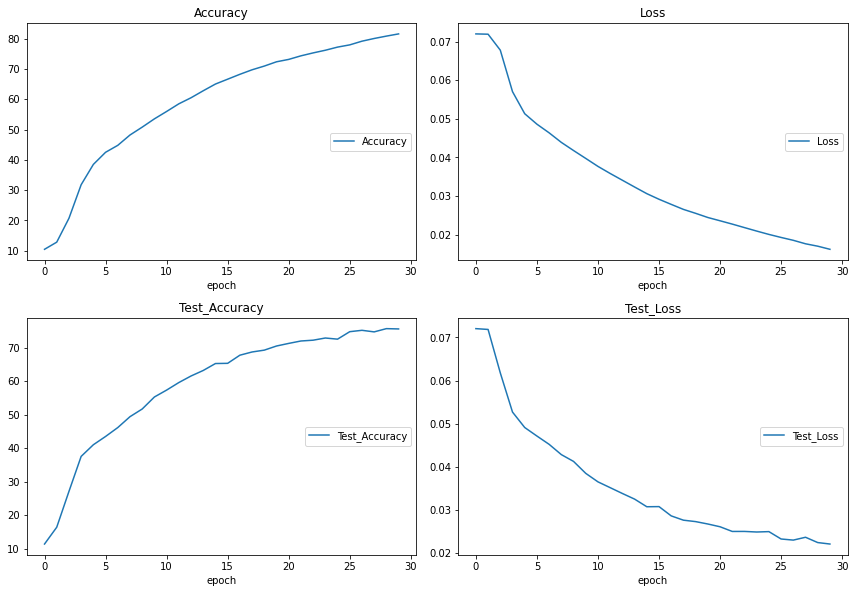

Accuracy
	Accuracy         	 (min:   10.476, max:   81.632, cur:   81.632)
Loss
	Loss             	 (min:    0.016, max:    0.072, cur:    0.016)
Test_Accuracy
	Test_Accuracy    	 (min:   11.420, max:   75.740, cur:   75.650)
Test_Loss
	Test_Loss        	 (min:    0.022, max:    0.072, cur:    0.022)
Finished Training


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type AlexNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
liveloss = PlotLosses()

for epoch in range(30):

    logs = {}

    for phase in ['train', 'test']:
        if phase == 'train':
            net.train()
        else:
            net.eval()

        total_count = 0.0
        correct_count = 0.0
        running_loss = 0.0
        prefix = ''
        for i, data in enumerate(dataloaders[phase], 0):
            inputs, lables = data
            inputs = inputs.to(device)
            lables = lables.to(device)

            if phase == 'train':
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, lables)
                loss.backward()
                optimizer.step()
                prefix = ''
            else:
                with torch.no_grad():
                    outputs = net(inputs)
                    loss = criterion(outputs, lables)
                    prefix = 'Test_'
 
            running_loss += loss.item()

            # accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_count += lables.size(0)
            correct_count += predicted.eq(lables.data).sum().item()

            
        logs[prefix+'Loss'] = running_loss / total_count
        accuracy = 100 * correct_count / total_count
        logs[prefix+'Accuracy'] = accuracy
    
    liveloss.update(logs)
    liveloss.draw()
 
print('Finished Training')
torch.save(net, './model2')

AlexNet(
  (conv1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), groups=2)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (conv5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
)


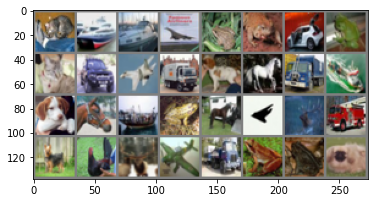

GroundTruth:    cat  ship  ship plane  forg  forg   car  forg   cat   car plane truck   dog horse truck  ship   dog horse  ship  forg horse plane  deer truck   dog  bird  deer plane truck  forg  forg   dog
Predicted:    dog   car  ship plane  forg  forg   car  forg   cat   car plane truck   dog horse truck  ship   dog horse  ship  forg horse plane  deer truck  deer  forg  deer plane truck  forg  forg   dog


In [ ]:
net = torch.load('./model2')
print(net)
 
 
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s'%classes[labels[j]] for j in range(32)))
 
 
images, labels = images.to(device), labels.to(device)
 
outputs = net(images)
predicted = torch.argmax(outputs,1)
print('Predicted: ',' '.join('%5s'%classes[predicted[j]] for j in range(32)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        predicted = torch.argmax(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the network on the 50000 train images: %d %%'%(100*correct/total))

Accuracy of the network on the 50000 train images: 83 %


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        predicted = torch.argmax(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the network on the 10000 test images: %d %%'%(100*correct/total))

Accuracy of the network on the 10000 test images: 75 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        predicted = torch.argmax(outputs.data,1)
        c = (predicted== labels)
        if len(c) == 16:
            for i in range(16):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += c[i].item()
        else:
            for i in range(32):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %2d %%'%(classes[i], 100*class_correct[i]/class_total[i]))

Accuracy of plane : 80 %
Accuracy of   car : 87 %
Accuracy of  bird : 61 %
Accuracy of   cat : 61 %
Accuracy of  deer : 73 %
Accuracy of   dog : 62 %
Accuracy of  forg : 83 %
Accuracy of horse : 79 %
Accuracy of  ship : 83 %
Accuracy of truck : 85 %
